#CS 156 Final Project

### Roster Name: Michael Wong
### Email Address: michael.y.wong@sjsu.edu
### Sources: https://www.kaggle.com/joshuaswords/predicting-a-stroke-shap-lime-explainer-eli5/notebook


##  <u> Project description/introduction text (the background information) </u>

The code in this project is attempting to look for the likelyhood of a stroke occuring based on certain bodily factors. This is at its core, a classification problem and three different types of machine learning algorithms will be used on them. I will be using Random Forest, Decision Tree and Logistical Regression on the data set to try and get the most accurate prediction that I can get.

##  <u> Machine learning algorithm selected for this project </u>

I am using a variety of machine learning algorithms. One thing that we did not learn in class that I am using in this project is scaling the data with SKlearn pipeline. At its core, my project is a Classification based project and therefore I will be using various classification algorithms in this project. I am using Linear SVC, Random Forest and Logistical Regression. 

##  <u> Dataset source </u>

https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

##  <u> References and sources </u>

https://www.kaggle.com/joshuaswords/predicting-a-stroke-shap-lime-explainer-eli5/notebook (Provided help in filling in missing BMI data as well as data balancing with SMOTE).

Homework Assignment 4

Homework Assignment 5

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
cd MyDrive

[Errno 2] No such file or directory: 'MyDrive'
/content/drive/MyDrive


##  <u>Solution</u>

In [91]:
#imports
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [92]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [93]:
#Code to search for and replace missing values. 
#This code uses decision trees to attempt to replicated missing information. 
#It is a more effective method than just using something like the mean or the median. 

df.isnull().sum()

DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi


In [94]:
print('Missing values: ',sum(df.isnull().sum()))

Missing values:  0


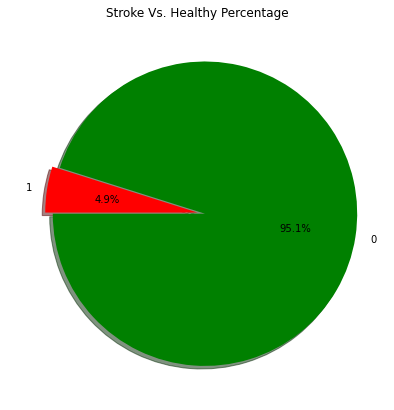

In [95]:
labels =df['stroke'].value_counts(sort = True).index
sizes = df['stroke'].value_counts(sort = True)

colors = ["green","red"]
explode = (0.05,0) 
 
plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=180,)

plt.title('Stroke Vs. Healthy Percentage')
plt.show()

In [96]:
#I tried using this data organization method from the homework. 
#An interesting thing I came across is the fact that because their are so many different ages and BMI's that the data is unusable in this way. 
#You can't cross validate data in this state. 

Y = df['id']
X = df.drop(['id'], axis=1)
X_numeric = pd.get_dummies(X, columns = X.columns, prefix = X.columns)
X_numeric.head()

,gender_Female,gender_Male,gender_Other,age_0.08,age_0.16,age_0.24,age_0.32,age_0.4,age_0.48,age_0.56,age_0.64,age_0.72,age_0.8,age_0.88,age_1.0,age_1.08,age_1.16,age_1.24,age_1.32,age_1.4,age_1.48,age_1.56,age_1.64,age_1.72,age_1.8,age_1.88,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,age_7.0,age_8.0,age_9.0,age_10.0,age_11.0,age_12.0,age_13.0,age_14.0,age_15.0,...,bmi_54.0,bmi_54.1,bmi_54.2,bmi_54.3,bmi_54.6,bmi_54.7,bmi_54.8,bmi_55.0,bmi_55.1,bmi_55.2,bmi_55.7,bmi_55.9,bmi_56.0,bmi_56.1,bmi_56.6,bmi_57.2,bmi_57.3,bmi_57.5,bmi_57.7,bmi_57.9,bmi_58.1,bmi_59.7,bmi_60.2,bmi_60.9,bmi_61.2,bmi_61.6,bmi_63.3,bmi_64.4,bmi_64.8,bmi_66.8,bmi_71.9,bmi_78.0,bmi_92.0,bmi_97.6,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke_0,stroke_1
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [97]:
#Encoding gender, residence type and work type as ints otherwise the modeling would not work. 
df['gender'] = df['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)
df['work_type'] = df['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype(np.uint8)

In [98]:
#Setting data up in X and Y format.
X  = df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']]
Y = df['stroke']

In [77]:
Y.head()

0    1
1    1
2    1
3    1
4    1
Name: stroke, dtype: int64

In [78]:
X.head()

,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi
0,0,67.0,0,1,0,228.69,36.600000
1,1,61.0,0,0,1,202.21,29.879487
2,0,80.0,0,1,0,105.92,32.500000
3,1,49.0,0,0,0,171.23,34.400000
4,1,79.0,1,0,1,174.12,24.000000


In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((4088, 7), (4088,), (1022, 7), (1022,))

In [80]:
#Data Balancing
oversample = SMOTE()
X_train_SMOTE, Y_train_SMOTE = oversample.fit_resample(X_train, Y_train.ravel())

### Build a random forest classifier

In [81]:
#Random Forest Classifier Model
model = RandomForestClassifier(max_depth=5, random_state=0)

cross_val_score(model,X_train_SMOTE,Y_train_SMOTE,cv=5)


array([0.82, 0.83, 0.84, 0.83, 0.86])

In [82]:
model.fit(X_train_SMOTE, Y_train_SMOTE)
print('Accuracy of linear SVC on training set: {:.2f}'.format(model.score(X_train_SMOTE, Y_train_SMOTE)))
print('Accuracy of linear SVC on test set: {:.2f}'.format(model.score(X_test, Y_test)))

Accuracy of linear SVC on training set: 0.84
Accuracy of linear SVC on test set: 0.78


Confusion matrix, without normalization
[[772 196]
 [ 25  29]]
Normalized confusion matrix
[[0.8  0.2 ]
 [0.46 0.54]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


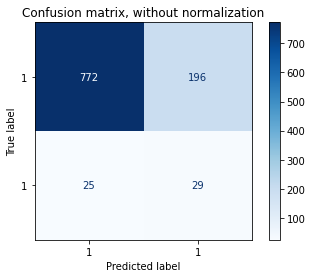

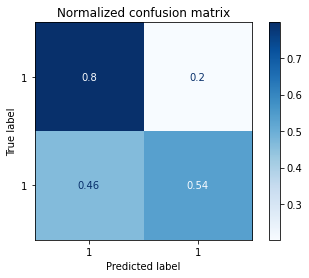

In [83]:
np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, Y_test,
                                 display_labels=Y,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

### Build a decision tree classifier

In [84]:
model = DecisionTreeClassifier(random_state=0)

# we can first score our model through cross validation (applicable to any supervised model we learn)
cross_val_score(model, X_train_SMOTE, Y_train_SMOTE, cv=5)

array([0.88, 0.92, 0.91, 0.9 , 0.92])

In [85]:
model.fit(X_train_SMOTE, Y_train_SMOTE)

print('Accuracy of linear SVC on training set: {:.2f}'.format(model.score(X_train_SMOTE, Y_train_SMOTE)))

print('Accuracy of linear SVC on test set: {:.2f}'.format(model.score(X_test, Y_test)))

Accuracy of linear SVC on training set: 1.00
Accuracy of linear SVC on test set: 0.87


Confusion matrix, without normalization
[[881  87]
 [ 41  13]]
Normalized confusion matrix
[[0.91 0.09]
 [0.76 0.24]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


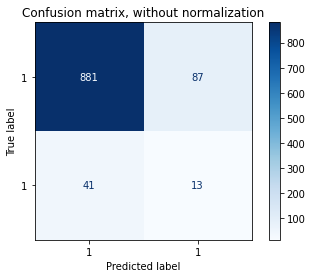

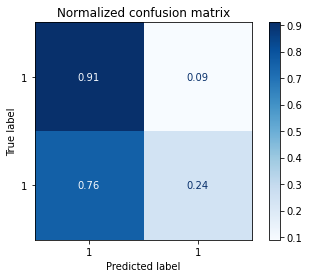

In [86]:
# this code is adopted from this example:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, Y_test,
                                 display_labels=Y,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

###Logistic Regression Modelling

In [87]:
model = LogisticRegression().fit(X_train_SMOTE, Y_train_SMOTE)

cross_val_score(model, X_train_SMOTE, Y_train_SMOTE, cv=5)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


array([0.79, 0.81, 0.82, 0.81, 0.83])

In [88]:
# The coefficients:
print('Coefficients: \n', model.coef_)

Y_test_pred = model.predict(X_test)

# The mean squared error:
print('Mean squared error: %.2f' % mean_squared_error(Y_test, Y_test_pred))

# The coefficient of determination (1 is perfect prediction):
print('Coefficient of determination: %.2f' % r2_score(Y_test, Y_test_pred))

Coefficients: 
 [[-1.00e+00  9.51e-02 -1.32e+00 -1.24e+00 -9.15e-01  4.87e-03  7.69e-04]]
Mean squared error: 0.22
Coefficient of determination: -3.46


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix, without normalization
[[765 203]
 [ 25  29]]
Normalized confusion matrix
[[0.79 0.21]
 [0.46 0.54]]


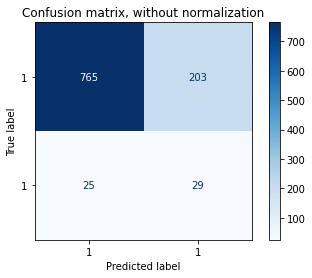

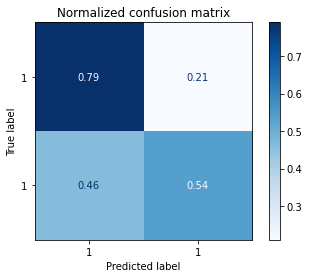

In [89]:
# this code is adopted from this example:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, Y_test,
                                 display_labels=Y,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()